# Wikispeedia

Imports

In [3]:
import pandas as pd
import networkx as nx
import nx_parallel as nxp
import matplotlib.pyplot as plt
import numpy as np
import random

import os
import json

from joblib import parallel_config, Parallel, delayed

Enable networkx's config for nx-parallel and set global configs

In [4]:
nx.config.backends.parallel.active = True

nxp_config = nx.config.backends.parallel
nxp_config.n_jobs = -1
nxp_config.verbose = 50

Read graph data

In [5]:
links = pd.read_csv('wikispeedia_paths-and-graph/links.tsv', delimiter='\t', names=['linkSource', 'linkTarget'], header=None, comment="#")
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', delimiter='\t', names=['article'], header=None, comment="#")

Read game data

In [4]:
paths_finished = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', delimiter='\t', usecols=[3], names=['path'], header=None, comment="#")
paths_finished['path'] = paths_finished['path'].apply(lambda x: x.split(';'))

paths_unfinished = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', delimiter='\t', usecols=[3, 4], names=['path', 'target'], header=None, comment="#")
paths_unfinished['path'] = paths_unfinished['path'].apply(lambda x: x.split(';'))

Filter game data to discard '<'

In [8]:
def filter_paths(paths):
    filtered_paths = [] 
    for path in paths:
        indices  = [index for (index, item) in enumerate(path) if item == '<']
        filter_indices = []; 
        for index in indices: filter_indices.extend([index - 1, index])
        filtered_paths.append([item for index, item in enumerate(path) if index not in filter_indices])
    return filtered_paths

paths_finished = filter_paths(paths_finished['path'])
paths_unfinished['path'] = filter_paths(paths_unfinished['path'])

In [9]:
paths_unfinished['path'][10][0]

'Battle_of_Gettysburg'

Generate the graph

In [6]:
G = nx.from_pandas_edgelist(links, source='linkSource', target='linkTarget')
disconnected_nodes = set(articles['article'].tolist()) - set(G.nodes)
G.add_nodes_from(disconnected_nodes)

H = nxp.ParallelGraph(G)

In [7]:
print(disconnected_nodes)

{'Underground_%28stories%29', 'Schatzki_ring', 'Donation', 'Douglas_DC-4', 'Color_Graphics_Adapter', 'Badugi', 'Suikinkutsu', 'Lone_Wolf_%28gamebooks%29', 'Wowpurchase', 'Private_Peaceful', 'Vacutainer', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'}


Plot the graph

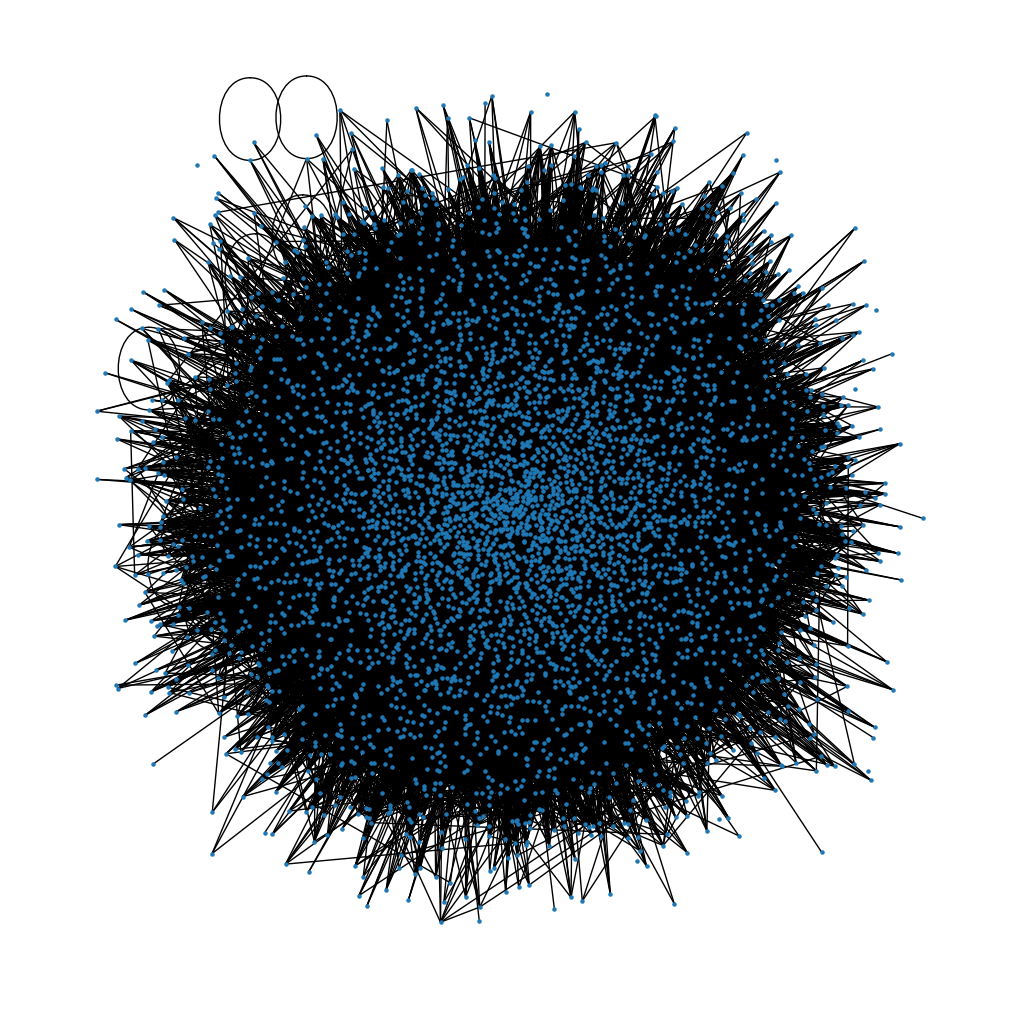

In [12]:
positions = nx.spring_layout(G, k=0.15, iterations=20)
plt.figure(1, figsize=(10, 10))
nx.draw(G, pos=positions, node_size=5)
plt.show()

Compute the shortest-path betweenness centrality for nodes (not approximated)

In [13]:
nodes_bc = nxp.betweenness_centrality(H);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.1min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  2.2min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  2.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  2.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  2.2min remaining:   43.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.2min finished


Analyze finished paths

In [14]:
unique_couples = []

for path in paths_finished:
    src = path[0]
    dst = path[-1]
    if(not [src, dst] in unique_couples):
        unique_couples.append([src, dst])

print(len(unique_couples))

28718


In [15]:
def shortest_paths_f(couple):
    try:
        shortest_paths_generator = nx.all_shortest_paths(G, couple[0], couple[1])
        shortest_paths = list(shortest_paths_generator)
        if not os.path.isdir('shortest_paths'):
            os.makedirs('shortest_paths')
        with open('shortest_paths/' + couple[0] + '#' + couple[1] + '.txt', 'w') as out_file:
            out_file.write(json.dumps(shortest_paths))
    except Exception as e:
        print(couple[0] + '#' + couple[1] + ' exception : ' + str(e))

In [16]:
Parallel(n_jobs=-1)(delayed(shortest_paths_f)(couple) for couple in unique_couples)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [17]:
def compare_paths(player_path, folder1, folder2):
    
    first_player_node = player_path[0]
    last_player_node = player_path[-1]
    
    try:
        with open(folder1 + '/' + first_player_node + '#' + last_player_node + '.txt') as in_file:
            optimal_paths = json.loads(in_file.read())

        best_beg_equal_nodes = 0
        best_end_equal_nodes = 0
        best_total_equal_nodes = 0
        
        for path in optimal_paths:
            
            i = 0
            while(i < len(path) and player_path[i] == path[i]): i = i + 1
            beg_equal_nodes = i
            
            i = -1
            while(i > -len(path) and player_path[i] == path[i]): i = i - 1
            end_equal_nodes = -i

            total_equal_nodes = len(list(set(path).intersection(player_path)))

            if beg_equal_nodes > best_beg_equal_nodes: best_beg_equal_nodes = beg_equal_nodes
            if end_equal_nodes > best_end_equal_nodes: best_end_equal_nodes = end_equal_nodes
            if total_equal_nodes > best_total_equal_nodes: best_total_equal_nodes = total_equal_nodes

        if not os.path.isdir(folder2):
            os.makedirs(folder2)
        with open(folder2 + '/' + first_player_node + '#' + last_player_node + '.txt', 'a') as out_file:
            out_file.write(
                str(len(path)) + ' ' + 
                str(len(player_path)) + ' ' +
                str(best_beg_equal_nodes) + ' ' + 
                str(best_end_equal_nodes) + ' ' + 
                str(best_total_equal_nodes) + '\n'
            )

    except Exception as e:
        print(first_player_node + '#' + last_player_node + ' exception : ' + str(e))
    
# Parallel(n_jobs=-1)(delayed(compare_paths)(path) for path in paths_finished)

for path in paths_finished:
    compare_paths(path, 'shortest_paths', 'equal_nodes')

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License exception : [Errno 2] No such file or directory: 'shortest_paths/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.txt'


KeyboardInterrupt: 

Analyze unfinished paths

In [ ]:
unique_unfinished_couples = []

for index, row in paths_unfinished.iterrows():
    src = row['path'][0]
    dst = row['target']
    if(not [src, dst] in unique_unfinished_couples):
        unique_unfinished_couples.append([src, dst])

Parallel(n_jobs=-1)(delayed(shortest_paths_f)(couple) for couple in unique_unfinished_couples)

In [ ]:
def compare_unfinished_paths(player_path, target, folder1, folder2):
    
    first_player_node = player_path[0]
    last_player_node = target
    
    try:
        with open(folder1 + '/' + first_player_node + '#' + last_player_node + '.txt') as in_file:
            optimal_paths = json.loads(in_file.read())

        best_beg_equal_nodes = 0
        best_total_equal_nodes = 0
        
        for path in optimal_paths:
            
            i = 0
            while(i < len(path) and i < len(player_path) and player_path[i] == path[i]): i = i + 1
            beg_equal_nodes = i

            total_equal_nodes = len(list(set(path).intersection(player_path)))

            if beg_equal_nodes > best_beg_equal_nodes: best_beg_equal_nodes = beg_equal_nodes
            if total_equal_nodes > best_total_equal_nodes: best_total_equal_nodes = total_equal_nodes

        if not os.path.isdir(folder2):
            os.makedirs(folder2)
        with open(folder2 + '/' + first_player_node + '#' + last_player_node + '.txt', 'a') as out_file:
            out_file.write(
                str(len(path)) + ' ' + 
                str(len(player_path)) + ' ' +
                str(best_beg_equal_nodes) + ' ' + 
                str(best_total_equal_nodes) + '\n'
            )

    except Exception as e:
        print(first_player_node + '#' + last_player_node + ' exception : ' + str(e))


for index, row in paths_unfinished.iterrows():
    compare_unfinished_paths(row['path'], row['target'], 'shortest_paths', 'equal_nodes_unfinished')

Length difference histogram for finished paths

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License : [Errno 2] No such file or directory: 'equal_nodes/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.txt'


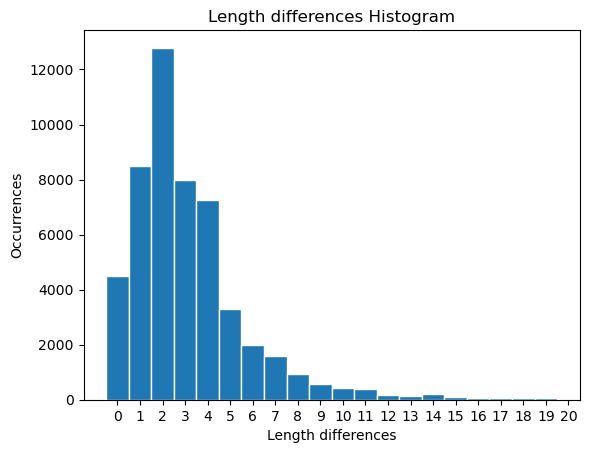

In [11]:
len_diff = []

for path in paths_finished:
    try:
        with open('equal_nodes' + '/' + path[0] + '#' + path[-1] + '.txt') as in_file:
            s = in_file.read().split()
            optimal_len = int(s[0])
            player_len = int(s[1])
            len_diff.append(player_len - optimal_len)
    except Exception as e:
        print(path[0] + '#' + path[-1] + ' : ' + str(e))

plt.hist(len_diff, bins=range(21), align='left', edgecolor='white')
plt.xticks(range(21))
plt.xlabel('Length differences')
plt.ylabel('Occurrences')
plt.title('Length differences Histogram')
plt.show()

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License : [Errno 2] No such file or directory: 'equal_nodes/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.txt'


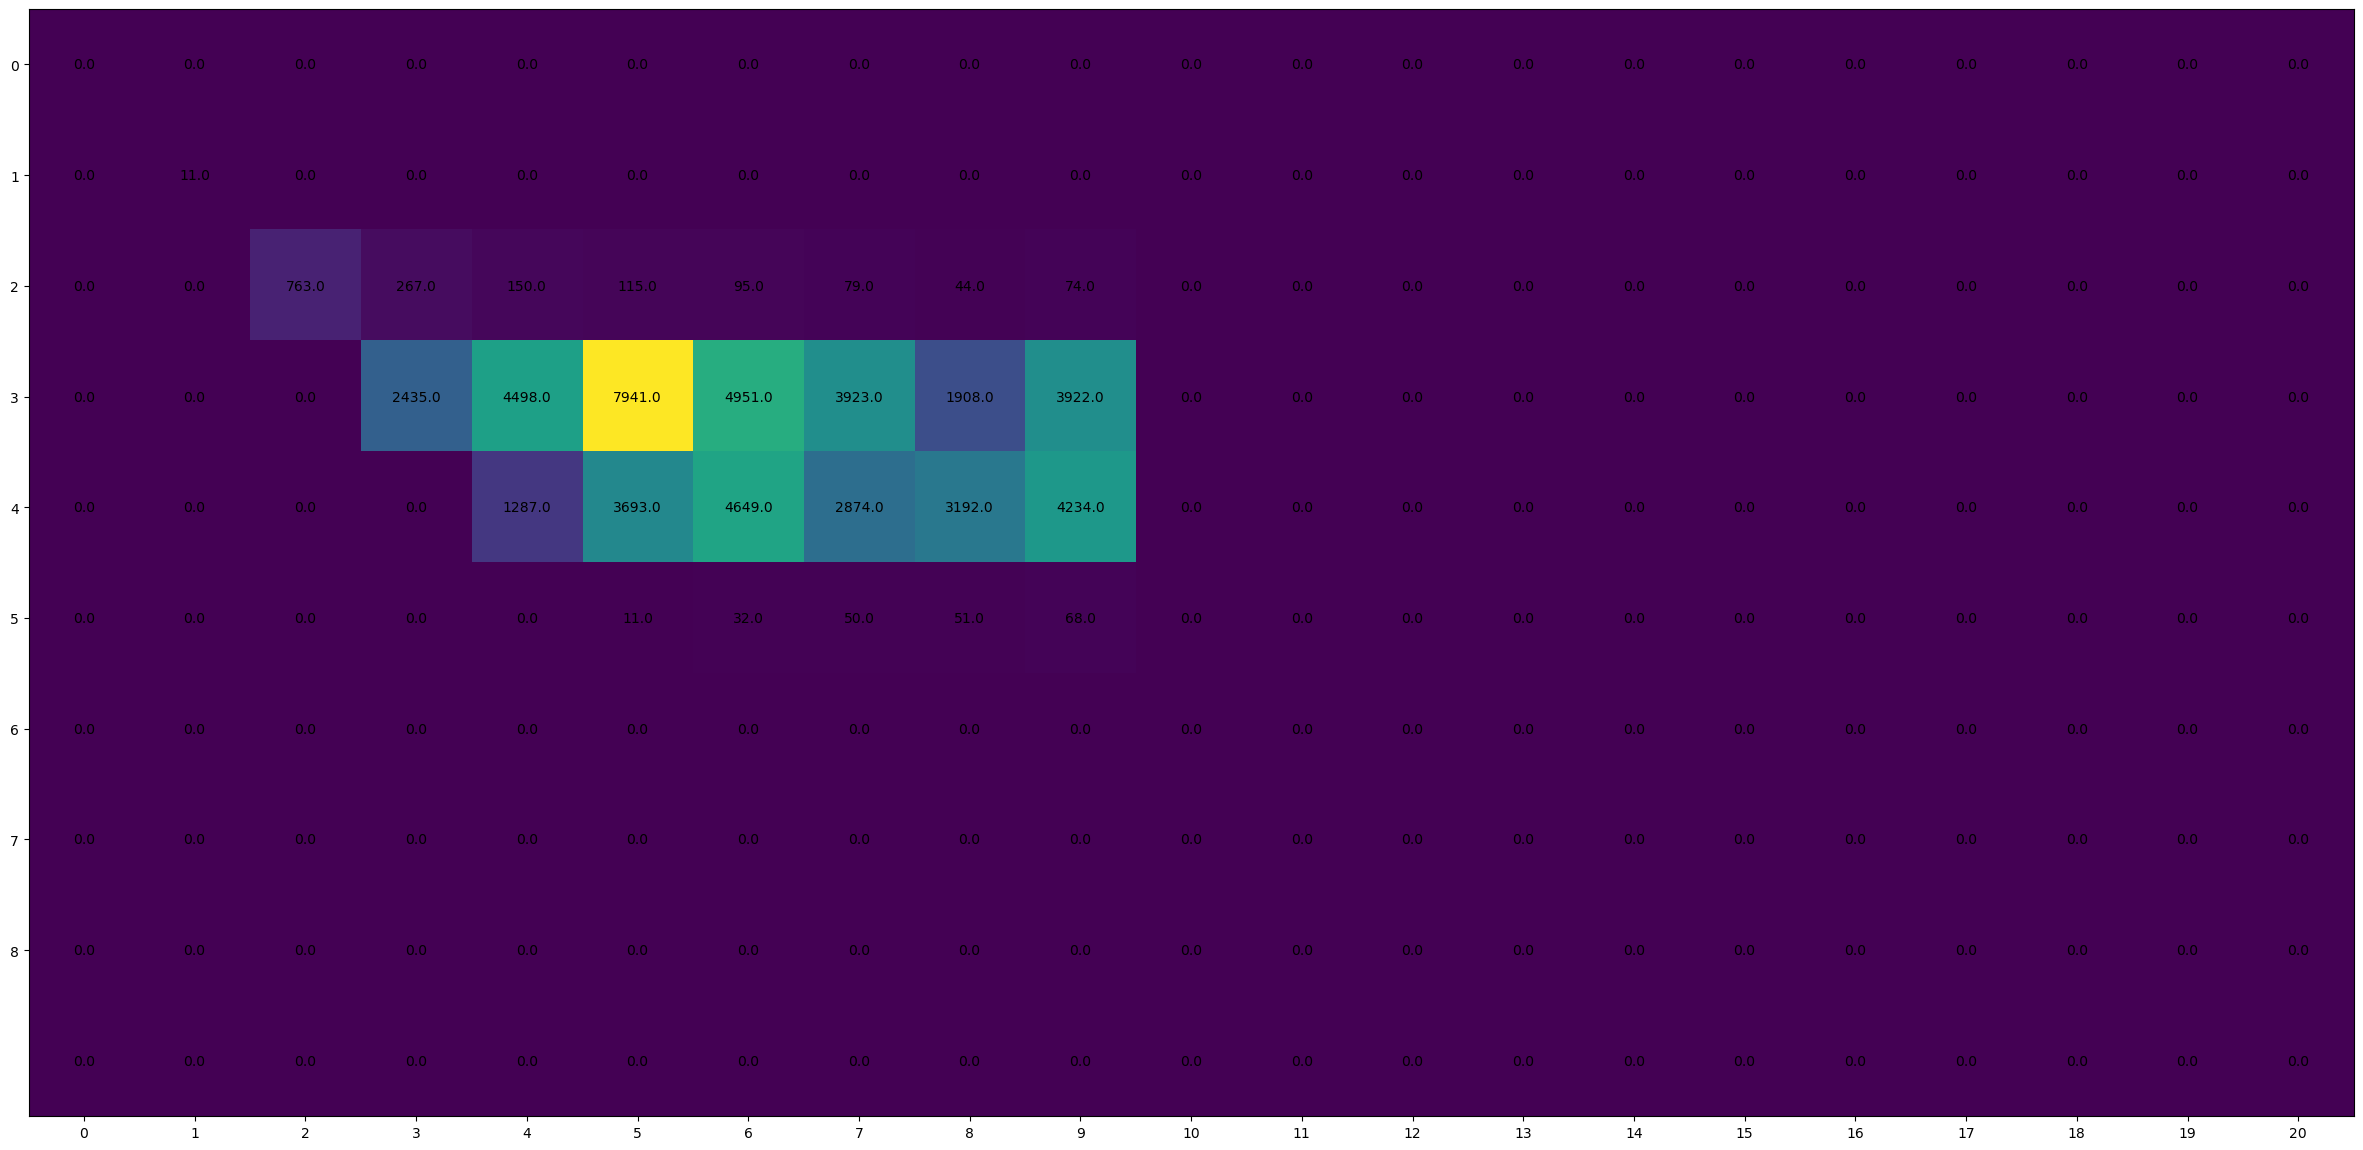

In [24]:
len_map = np.zeros((10, 21))
optimal_len_freq = np.zeros(10)

for path in paths_finished:
    try:
        with open('equal_nodes' + '/' + path[0] + '#' + path[-1] + '.txt') as in_file:
            s = in_file.read().split()
            optimal_len = int(s[0])
            optimal_len_freq[optimal_len] = optimal_len_freq[optimal_len] + 1
            player_len = int(s[1])
            player_len = min(player_len, 9)
            len_map[optimal_len][player_len] = len_map[optimal_len][player_len] + 1
    except Exception as e:
        print(path[0] + '#' + path[-1] + ' : ' + str(e))
        
#for index in range(len(len_map)):
#    len_map[index] = len_map[index]/optimal_len_freq[index]
plt.figure(figsize=(30, 30))
plt.imshow(len_map)
plt.xticks(range(21))
plt.yticks(range(9))
for (j,i),label in np.ndenumerate(len_map):
    plt.text(i,j,label,ha='center',va='center')

Visualize the 10 most central nodes, with respect to the betweennes centrality and count how many users used them to conclude their game

In [22]:
sorted_bc = sorted(nodes_bc.items(), key=lambda item: item[1], reverse=True)
for i in range(1, 11):
  print(i, sorted_bc[i])

for i in range(1, 11):
  count = 0
  for path in paths_finished:
    if sorted_bc[i][0] in path:
      count += 1
  print("Percentage of", sorted_bc[i][0], "=", count/len(paths_finished))

1 ('United_Kingdom', 0.047140056743262077)
2 ('Europe', 0.04442508677538769)
3 ('France', 0.03661771007015328)
4 ('England', 0.03342206625169744)
5 ('World_War_II', 0.025432353143485176)
6 ('Germany', 0.023007921661402024)
7 ('English_language', 0.020111050737573844)
8 ('Africa', 0.01974485634533934)
9 ('London', 0.018907246019044824)
10 ('Australia', 0.01739070176832979)
Percentage of United_Kingdom = 0.07217740364004832
Percentage of Europe = 0.08256362290034686
Percentage of France = 0.029697182275225067
Percentage of England = 0.061459916598464476
Percentage of World_War_II = 0.04288943450641101
Percentage of Germany = 0.033126778128531896
Percentage of English_language = 0.026657313223430377
Percentage of Africa = 0.05237928212323161
Percentage of London = 0.017888460189407224
Percentage of Australia = 0.018745859152733933



Method to perform a random walk of at most n steps

In [23]:
def do_random_walk(g, source, destination, n):
  crossed_nodes = []
  current_node = source
  crossed_nodes.append(current_node)
  for i in range(n):
    if current_node == destination:
      break
    list_neighbors = list(g.neighbors(current_node))
    if len(list_neighbors)==0:
      break
    else:
      current_node = random.choice(list_neighbors)
      crossed_nodes.append(current_node)
  return crossed_nodes

Perform "number_of_random_attempts" random walks on a subset of source and destination nodes picked casually

In [ ]:
number_of_finished_paths = 20
number_of_random_attempts = 20
max_steps = 100

for i in range(number_of_finished_paths):
  random_i = random.choice([i for i in range(len(paths_finished))])
  source, destination = paths_finished[random_i][0], paths_finished[random_i][-1]
  print(source, "-->", destination)
  for j in range(number_of_random_attempts):
    crossed_nodes = do_random_walk(G, source, destination, max_steps)
    if crossed_nodes[-1] == destination:
      print("Correct path:, number of steps:", len(crossed_nodes))
      print(crossed_nodes)
    #else:
      #print("Wrong random path")

# Clustering

## Performing Greedy Clustering
### Execution time: 3 min

In [99]:
greedy_clustering = nx.algorithms.community.greedy_modularity_communities(G)

In [100]:
for i, clust in enumerate(greedy_clustering):
    print(f"Cluster {i+1}: {sorted(clust)} \n\n\n")

Cluster 1: ['16_Cygni', '16_Cygni_Bb', '1928_Okeechobee_Hurricane', '1980_eruption_of_Mount_St._Helens', '1997_Pacific_hurricane_season', '1_Ceres', '2-6-0', '2-8-0', '2003_Atlantic_hurricane_season', '2004_Atlantic_hurricane_season', '2004_Indian_Ocean_earthquake', '2005_Atlantic_hurricane_season', '2005_Kashmir_earthquake', '3_Juno', '4-2-0', '4-4-0', '4-6-0', '47_Ursae_Majoris', '47_Ursae_Majoris_b', '47_Ursae_Majoris_c', '4_Vesta', '55_Cancri', '55_Cancri_b', '55_Cancri_c', '55_Cancri_d', '55_Cancri_e', '6-2-0', '90377_Sedna', 'ABO_blood_group_system', 'AC_DC', 'AIDS', 'ALCO_FA', 'AT%26T', 'ATLAS_experiment', 'Aardvark', 'Abac%C3%A1', 'Abadan', 'Abel_Tasman', 'Aberration_of_light', 'Abraham_Lincoln', 'Absinthe', 'Absolute_zero', 'Acceleration', 'Acetic_acid', 'Acetone', 'Acid_rain', 'Actinium', 'Action_potential', 'Adenosine_triphosphate', 'Advertising', 'Afghan_Hound', 'African_American_literature', 'African_Black_Oystercatcher', 'African_Brush-tailed_Porcupine', 'African_Buffalo'

## Performing Louvian Clustering

In [101]:
louv_clustering = nx.algorithms.community.louvain_communities(G, seed = 587)
louv_clustering = sorted(louv_clustering, key=len, reverse=True)

In [102]:
for i, clust in enumerate(louv_clustering):
    print(f"Cluster {i+1}: {sorted(clust)} \n\n\n")

Cluster 1: ['%C3%89douard_Manet', '10th_century', '11th_century', '12th_century', '13th_century', '14th_century', '15th_century', '16th_century', '1755_Lisbon_earthquake', '17th_century', '18th_century', '19th_century', '1st_century', '1st_century_BC', '2005_Kashmir_earthquake', '20th_century', '2nd_century', '3rd_century', '4th_century', '5th_century', '6th_century', '7th_century', '8th_century', '9th_century', 'A_Wrinkle_in_Time', 'A_cappella', 'Aachen', 'Abbadid', 'Abbas_I_of_Persia', 'Abbasid', 'Abhidhamma_Pitaka', 'Abstract_art', 'Abu_Dhabi', 'Accountancy', 'Achilles', 'Achilles_tendon', 'Actuary', 'Adam_Smith', 'Adi_Shankara', 'Aesthetics', 'Afghanistan', 'Agamemnon', 'Age_of_Enlightenment', 'Agnosticism', 'Akbar', 'Akhenaten', 'Akkadian_Empire', 'Aksumite_currency', 'Albigensian_Crusade', 'Albrecht_D%C3%BCrer', 'Alcibiades', 'Aleksandr_Pushkin', 'Alexander_the_Great', 'Alfred_Nobel', 'Algebra', 'Algiers', 'Allah', 'Allegory_in_the_Middle_Ages', 'Almaty', 'Alphabet', 'Amda_Seyon_

## Connected components

In [103]:
connected_components = nx.connected_components(G)
for i, component in enumerate(connected_components):
    print(f"Component {i+1}: {component} \n\n\n")

Component 1: {'David_Copperfield_%28novel%29', 'Day', 'Korea', 'Mount_Vesuvius', 'Binomial_nomenclature', 'Hymenoptera', 'Visual_arts', 'Annibale_Bugnini', 'GNU_Linux_naming_controversy', 'Gas_metal_arc_welding', 'Edward_the_Confessor', 'Jane_Austen', 'History_of_Louisville%2C_Kentucky', 'Household_income_in_the_United_States', 'Yorkshire_Dales', 'Shroud_of_Turin', 'Crime_and_Punishment', 'Milgram_experiment', 'Cosmic_microwave_background_radiation', 'Manifold', 'Westminster_System', 'Confucianism', 'Cello', 'Elfin-woods_Warbler', 'Cattle', 'Spanish_Inquisition', 'Grape_seed_oil', 'Yotsuya_Kaidan', 'Star_Trek__Deep_Space_Nine', 'List_of_monarchs_in_the_British_Isles', 'Star_anise', 'Las_Palmas_de_Gran_Canaria', 'Corinthian_War', 'China', 'Post-glacial_rebound', 'Louis_Armstrong', 'Southern_Africa', 'John_Dee', 'Olive_oil', 'Corn_oil', 'Indian_Standard_Time', 'Tagoi_language', 'Community', 'Rugby_World_Cup', 'Jacques_Cartier', 'Writing', 'Medieval_music', 'Programming_language', 'Monopo

## Categories

In [104]:
article_categ = pd.read_csv('wikispeedia_paths-and-graph/categories.tsv', delimiter='\t', names=['articles','categories'], header=None, comment="#")
article_categ['categories'] = article_categ['categories'].str.split('.').str.get(1)  #to get only the first category after "subject"
categories_set = set(article_categ['categories'])
categories_set.add("NOTAG")
print(categories_set)

{'Language_and_literature', 'People', 'Science', 'Countries', 'Citizenship', 'Business_Studies', 'Art', 'Mathematics', 'Design_and_Technology', 'Music', 'Geography', 'History', 'IT', 'Religion', 'NOTAG', 'Everyday_life'}


In [105]:
article_categ.to_csv('couple_art_cat.tsv', sep='\t', index=False, header=True)
no_tag_articles = articles[~articles['article'].isin(article_categ['articles'])]['article'].tolist() #to get the articles that have no category
print(no_tag_articles)

for art in no_tag_articles:                                                                         #adding them in the article_categ dataframe
    new_row = pd.DataFrame({'articles': art, 'categories': ["NOTAG"]})
    article_categ = pd.concat([article_categ, new_row], ignore_index=True)

['Directdebit', 'Donation', 'Friend_Directdebit', 'Pikachu', 'Sponsorship_Directdebit', 'Wowpurchase']


In [106]:
art_cat_sets = article_categ.groupby('articles', as_index=False)['categories'].apply(lambda x: set(x)) #to remove duplicates
art_cat_sets.to_csv('Sets_Art_Cat.tsv', sep='\t', index=False, header=True)

## Articles with multiple categories

In [107]:
max_cardinality = art_cat_sets['categories'].apply(len).max()

for i in range(1,max_cardinality+1):
    articles_with_i_cat = art_cat_sets[art_cat_sets['categories'].apply(len) == i]

    print("There are "+str(len(articles_with_i_cat))+" articles with cardinality "+str(i) + " :")
    if(i==max_cardinality):
        print(articles_with_i_cat)

There are 4098 articles with cardinality 1 :
There are 505 articles with cardinality 2 :
There are 1 articles with cardinality 3 :
     articles                              categories
3332  Pottery  {Art, Business_Studies, Everyday_life}


## Categories of the clusters

In [108]:
def dict_categories_list(G, clustering, art_cat_sets, toPrint = False):

    dict_cat_list = {i: {key: [] for key in categories_set } for i in range(len(clustering))}
    for i, clust in enumerate(clustering):
        for article in list(G.nodes):
            if article in clust:
                if article in art_cat_sets['articles'].values:
                    for categ in art_cat_sets.loc[art_cat_sets['articles'] == article, 'categories'].values[0]:
                        dict_cat_list[i][categ].append(article)
    if toPrint:
        for clust in dict_cat_list:
            print("Cluster " +str(clust+1)+":")
            for key in dict_cat_list[clust]:
                if dict_cat_list[clust][key]:
                    print(str(key)+"\t" +str(dict_cat_list[clust][key]))
                    print("\n")
            print("\n ################################################################################################################################################################################################## \n")
    
    return dict_cat_list
                        

In [109]:
greedy_dict = dict_categories_list(G, greedy_clustering, art_cat_sets, True)

Cluster 1:
Language_and_literature	['Technology', 'Spanish_language', 'African_American_literature', 'American_English', 'Canadian_English', 'Porgy_and_Bess', 'Nahuatl_language', 'Charlotte%27s_Web', 'The_Old_Man_and_the_Sea', 'Kigo', 'Madama_Butterfly', 'Theatre_in_the_round', 'Voynich_manuscript', 'The_Oz_books', 'Yotsuya_Kaidan']


People	['Christopher_Columbus', 'Galileo_Galilei', 'Leif_Ericson', 'Hern%C3%A1n_Cort%C3%A9s', 'Jacques_Cartier', 'Isaac_Newton', 'Johannes_Kepler', 'Alexander_Hamilton', 'Antoine_Lavoisier', 'Benjamin_Franklin', 'Carolus_Linnaeus', 'Edmond_Halley', 'Edward_Jenner', 'George_Washington', 'James_Cook', 'Thomas_Jefferson', 'Vitus_Bering', 'Richard_Nixon', 'Jimmy_Carter', 'Abraham_Lincoln', 'Alexander_Graham_Bell', 'Andrew_Jackson', 'Charles_Darwin', 'Dmitri_Mendeleev', 'Gregor_Mendel', 'James_Clerk_Maxwell', 'Louis_Pasteur', 'Marie_Curie', 'Mark_Twain', 'Michael_Faraday', 'Nikola_Tesla', 'Sitting_Bull', 'Ulysses_S._Grant', 'Bill_Clinton', 'George_H._W._Bush',

In [110]:
louv_dict = dict_categories_list(G, louv_clustering, art_cat_sets, True)

Cluster 1:
Language_and_literature	['Novel', 'Arabic_language', 'Opera', 'Wolfgang_Amadeus_Mozart', 'Giuseppe_Verdi', 'Henrik_Ibsen', 'Literature', 'Richard_Wagner', 'Language', 'Vulgar_Latin', 'Theatre', 'A_Wrinkle_in_Time', 'German_language', 'Latin', 'Hindi', 'Chinese_language', 'Hebrew_language', 'Poetry', 'Samuel_Beckett', 'Sanskrit', 'Drama', 'H%C3%A4nsel_und_Gretel', 'The_Marriage_of_Figaro', 'Persian_literature', 'Linguistics', 'Frankenstein', 'Mythology', 'Esperanto', 'Medieval_literature', 'Alphabet', 'Latin_alphabet', 'Tamil_language', 'Graphic_novel', 'Noam_Chomsky', 'Vowel', 'Writing', 'Ramayana', 'Anglo-Saxon_literature', 'T._S._Eliot', 'The_Hobbit', 'The_Lord_of_the_Rings', 'Anna_Karenina', 'Indonesian_language', 'Aradia%2C_or_the_Gospel_of_the_Witches', 'Arcadia_%28play%29', 'Epic_of_Gilgamesh', 'Augusta%2C_Lady_Gregory', 'Augustan_literature', 'Robinson_Crusoe', 'War_and_Peace', 'The_Lion%2C_the_Witch_and_the_Wardrobe', 'The_Cantos', 'Book', 'Jane_Eyre', 'The_Pilgrim%2

In [111]:
def dict_categ_cardinality_per_cluster(alg_dict, toPrint = False):
    perc_dict = {clust: {categ: len(alg_dict[clust][categ]) for categ in alg_dict[0] } for clust in range(len(alg_dict))}
    
    for clust in alg_dict:
        print("Clustering :" + str(clust+1))
        for categ in alg_dict[clust]:
            if toPrint:
                print(str(str(categ)+":\t\t\t"+"{:d}".format(perc_dict[clust][categ])).rjust(40))
    return perc_dict

In [112]:
greedy_card_dict = dict_categ_cardinality_per_cluster(greedy_dict,True)

Clustering :1
           Language_and_literature:			15
                           People:			193
                         Science:			1052
                         Countries:			44
                       Citizenship:			50
                  Business_Studies:			30
                                Art:			4
                        Mathematics:			4
            Design_and_Technology:			136
                             Music:			59
                        Geography:			469
                           History:			80
                                 IT:			9
                           Religion:			9
                              NOTAG:			1
                    Everyday_life:			181
Clustering :2
          Language_and_literature:			146
                           People:			407
                           Science:			17
                        Countries:			180
                      Citizenship:			140
                  Business_Studies:			32
                               Art:			30
                        Mathe

In [113]:
louv_card_dict = dict_categ_cardinality_per_cluster(louv_dict,True)

Clustering :1
           Language_and_literature:			99
                           People:			223
                           Science:			38
                         Countries:			17
                       Citizenship:			79
                  Business_Studies:			26
                               Art:			32
                       Mathematics:			37
             Design_and_Technology:			34
                             Music:			20
                        Geography:			154
                          History:			185
                                 IT:			2
                         Religion:			106
                              NOTAG:			0
                     Everyday_life:			44
Clustering :2
           Language_and_literature:			20
                           People:			208
                           Science:			32
                          Countries:			7
                       Citizenship:			48
                  Business_Studies:			26
                                Art:			2
                        Mathe

## Plotting the results

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as cm
from matplotlib import colormaps

def show_partial_plot_clustering(card_dict,plot_title,start_pos,end_pos,fig_len, big_val):

    data_dicts =  list(card_dict.values())[start_pos:end_pos + 1]
    data_dicts
    # Number of dictionaries
    k = len(data_dicts)
    categories = list(data_dicts[0].keys())
    x_positions = np.arange(k)  # Positions for bar groups
        
    num_categories = len(categories)
    #cmap = cm.get_cmap('tab20c_r',num_categories)  # You can choose other colormaps like 'viridis', 'plasma', etc.
    #colors = [cmap(i / num_categories) for i in range(num_categories)]
    # Initialize figure
    fig, ax = plt.subplots(figsize=(fig_len,5))
    colors = plt.cm.tab20(np.linspace(0,1,num_categories))

    # Initialize the bottom tracker for each bar group
    bottom_values = [0] * k  

    # Plot stacked bars for each category
    

    for i, category in enumerate(categories):
        heights = [data[category] for data in data_dicts]
        ax.bar(x_positions, heights, bottom=bottom_values, label=category, color = colors[i])
        # Update the bottom tracker
        bottom_values = [bottom + height for bottom, height in zip(bottom_values, heights)]

    # Customization
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"{i+start_pos+1}" for i in range(k)])
    if(big_val):
        ax.set_ylim(0, 2500)
    else:
        ax.set_ylim(0, 35)
    ax.set_title(plot_title)
    ax.set_xlabel("Clusters")
    ax.set_ylabel("Cumulative categories cardinality")
    ax.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig('images/clustering/'+plot_title+'.png', dpi=300, bbox_inches='tight')
    plt.show()
   


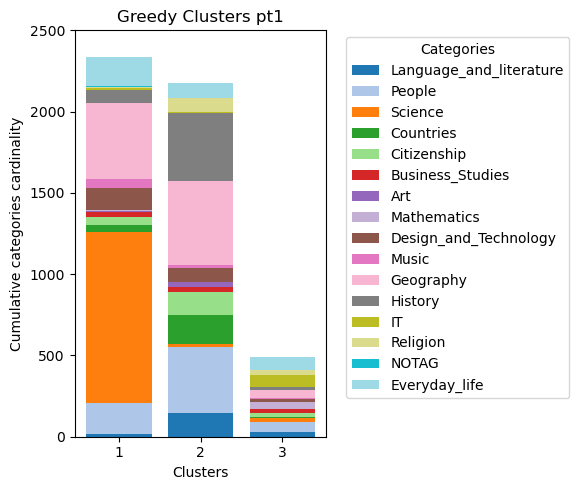

In [115]:
show_partial_plot_clustering(greedy_card_dict,"Greedy Clusters pt1",0,2,6,True)

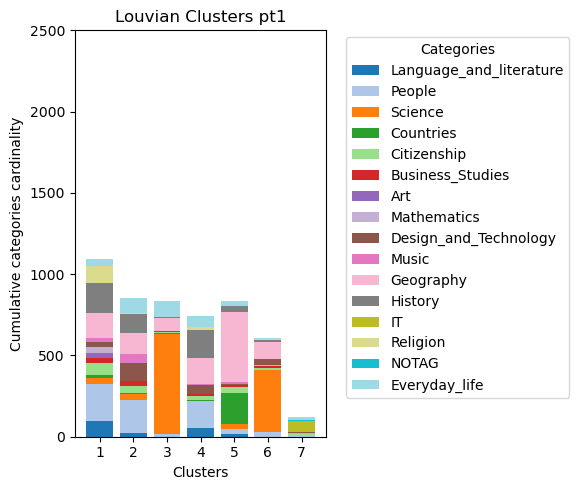

In [116]:
show_partial_plot_clustering(louv_card_dict,"Louvian Clusters pt1",0,6,6,True)

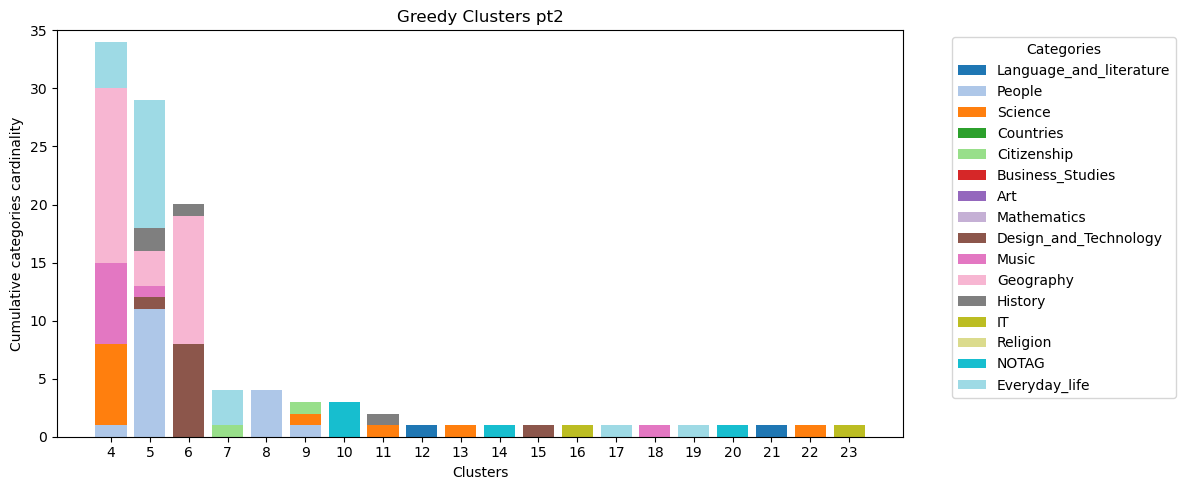

In [117]:
show_partial_plot_clustering(greedy_card_dict,"Greedy Clusters pt2",3,len(greedy_card_dict),12,False)

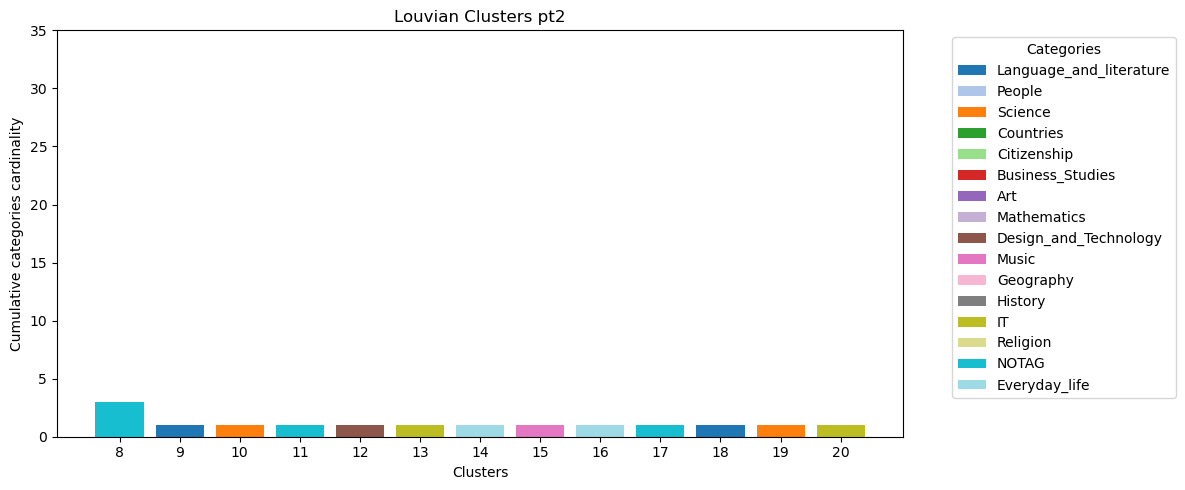

In [118]:
show_partial_plot_clustering(louv_card_dict,"Louvian Clusters pt2",7,len(louv_card_dict),12,False)